In [115]:
#libraries to use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests as rq
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

# General comments about this report
- Both Exploration and analysis and Model Construction are included in this notebook
- General structure for both challenges:
    - Data set construction: part 1 and part 2
    - Data analysis
    - Comments

## Exploration and analysis  
A sample was built to analyse items on sale. API request were made in the Mercado Libre Colombia site with the purpose to obtain all the price values in COP. This dataset was built based on the following categories: 

In [2]:
#Categories exploration. 
urlCat = "https://api.mercadolibre.com/sites/MCO/categories" #URL definition
rCat= rq.get(urlCat) #request to the Mercado Libre API
rCatJ=rCat.json() #conversion to java script object to facilitate magement 
dfCat = pd.DataFrame(rCatJ) #data frame construction from rCatJ
dfCat #print data frame

,id,name
0,MCO1747,Accesorios para Vehículos
1,MCO441917,Agro
2,MCO1403,Alimentos y Bebidas
3,MCO1071,Animales y Mascotas
4,MCO1367,Antigüedades y Colecciones
5,MCO1368,"Arte, Papelería y Mercería"
6,MCO1384,Bebés
7,MCO1246,Belleza y Cuidado Personal
8,MCO40433,Boletas para Espectáculos
9,MCO1039,Cámaras y Accesorios


#### from the list above the following categories were included in the data set: "Música y películas", "Libros, Revistas y Cómics", "Instrumentos musicales", "Arte, Librería y Cordonería". 

In [3]:
lCatRef=(dfCat['id'][5],dfCat['id'][13],dfCat['id'][22],dfCat['id'][24],dfCat['id'][25]) #list of catergories ids
smallCat=dfCat.loc[dfCat['id'].isin(lCatRef)] #dataframe that contains filtered id and names
input_ds1=list(smallCat['id']) #input for ds1 function presented below
smallCat

,id,name
5,MCO1368,"Arte, Papelería y Mercería"
13,MCO1144,Consolas y Videojuegos
22,MCO1182,Instrumentos Musicales
24,MCO3025,"Libros, Revistas y Comics"
25,MCO1168,"Música, Películas y Series"


### Data frame construction
stimated run time: 12 min


#### Part 1

 It was noted that when a request was made based only on a category, a lot of attributes for the products hidden. I avoid loss of 
information dataset construction was performed in two parts The first one, retrieves two data sets `cct_sale` and `originals_cat` . `cct_sale` contains information about products ids that are going to be used in the second part. The second dataframe contains informations of parents categories names and ids. This dataframe was necesary to analyze only the 5 categories originally proposed instead of any child category that could be obtained in requests. 

Before constructing the data frame some attributes were excluded based on the following reasons

- because it was related to new id :descriptions, 'catalog_product_id'
- because it was related to images or videos: thumbnail_id',thumbnail,'secure_thumbnail','pictures','video_id'
- because it contained liks to websited:permalink,
- interesting but were ingnored for simplicity:'tags','deal_ids','coverage_areas'
- Other reasons:'non_mercado_pago_payment_methods', 'seller_contact', 'location'(information in address),  'attributes'(subcategories not relevant),'warnings'(empty), variations(empty), 'sub_status'(empty),'channels' 


In [4]:
def ds1(inp='insert category id'):
    """
    This function constructs a data set from an array that contains data frames of products from categories chosen, 
    making a request to 'https://api.mercadolibre.com/sites/MCO/search?category=%parameters' and then it merges them to a final 
    dataframe
    Input should be an array with categories and name categories
    Initial number of products it is defined by cond (asociated to number of result pages to be indexed) and number of 
    categories
    Deletes the articles that are not in sale
    Deletes duplicated products
    """
    #df split
    cat=list(inp['id'])
    cName=list(inp['name'])
    #
    urls=[]
    originals_cat=pd.DataFrame([])# dataframe constructed to replace category_id column in order to keep only parent categories
    arr = np.arange(len(cat))
    cond= [0,50,100,150,200,250,300,350]
    arr2= np.arange(len(cond))
    for i in arr:
        ref=cat[i]
        ref3=cName[i]
        for p in range(400): 
            originals_cat=originals_cat.append({'category_id':ref,'CatName':ref3}, ignore_index=True)
        for k in arr2:
            ref2=cond[k]
            urli='https://api.mercadolibre.com/sites/MCO/search?category={}&offset={}&limit=50'.format(ref,ref2)
            urls.append(urli)
        
    dfs=list(np.zeros(len(urls)))
    arr3=np.arange(len(urls))
    #parent
    for j in arr3:
        reqRef=rq.get(urls[j])
        rRefJ=reqRef.json()
        resRef=rRefJ['results']
        dfName='dfs{}'.format(j)
        dfName=pd.DataFrame(resRef)
        dfs[j]=dfName
  
    cct=pd.concat(dfs, ignore_index=True)
    cct['category_id']=originals_cat['category_id']
    cct['CatName']=originals_cat['CatName']
    cct.drop_duplicates(subset ="id",keep = 'first', inplace = True)#duplicates elimination, useful for elements that might be in multiple categories, can't be used if dtype=object is present
    cct2=cct.reset_index(drop=True)#index reorganization
    is_sale=pd.isna(cct2['original_price'])
    cct_sale_i=cct2[is_sale]
    cct_sale=cct_sale_i.reset_index(drop=True)
    return cct_sale

In [5]:
#list of id_products definition
products_in_categories=ds1(smallCat)
id_list=products_in_categories[['id','category_id','CatName']]
id_list

,id,category_id,CatName
0,MCO590825297,MCO1368,"Arte, Papelería y Mercería"
1,MCO594412765,MCO1368,"Arte, Papelería y Mercería"
2,MCO600289962,MCO1368,"Arte, Papelería y Mercería"
3,MCO570929580,MCO1368,"Arte, Papelería y Mercería"
4,MCO513434416,MCO1368,"Arte, Papelería y Mercería"
...,...,...,...
1862,MCO566511176,MCO1168,"Música, Películas y Series"
1863,MCO580925109,MCO1168,"Música, Películas y Series"
1864,MCO612238073,MCO1168,"Música, Películas y Series"
1865,MCO498703965,MCO1168,"Música, Películas y Series"


#### Part 2
To obtain the data from each article a new dataframe was constructed.

In [6]:
#DF from list id 
def ds1_f(lista='insert list of id products'):
    """
    This function constructs a data set from a list that contains ids of products, making a request in 
    'https://api.mercadolibre.com/items/{}'
    Only certain attributes are chosen to built the data frame (see explanation above)

    """
    urls=[]
    #arr = np.arange(len(cat))
    for i in lista:
        ref=i
        urli='https://api.mercadolibre.com/items/{}'.format(ref)
        urls.append(urli)
        dfs=[]
        #arr3=np.arange(len(urls))
    for j in urls:
        temp_url=j
        temp_req=rq.get(temp_url)
        temp_json=temp_req.json()
        small_json={key: temp_json[key] for key in temp_json.keys()&{'id','site_id','title','subtitle','seller_id','category_id',
                                                                   'official_store_id','price','base_price','original_price',
                                                                   'currency_id','initial_quantity','available_quantity','sold_quantity',
                                                                  'buying_mode','listing_type_id','start_time','stop_time','condition',
                                                                  'accepts_mercadopago','shipping','international_delivery_mode',
                                                                  'seller_address','buying_mode','listing_source','status','warranty',
                                                                    'parent_item_id','differential_pricing','automatic_relist',
                                                                   'date_created','last_updated','health','catalog_listing'}}
        l_json=list(small_json.items())
        temp_df='dfs{}'.format(j)
        temp_df=pd.DataFrame(small_json,index=[0])
        dfs.append(temp_df)

    cct=pd.concat(dfs, ignore_index=True)
    return cct
    


In [7]:
salida=ds1_f(id_list['id'])
salida['CatName']=id_list['CatName']
salida.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   title                        1867 non-null   object 
 1   status                       1867 non-null   object 
 2   shipping                     0 non-null      float64
 3   buying_mode                  1867 non-null   object 
 4   listing_source               1867 non-null   object 
 5   catalog_listing              1867 non-null   bool   
 6   stop_time                    1867 non-null   object 
 7   initial_quantity             1867 non-null   int64  
 8   currency_id                  1867 non-null   object 
 9   subtitle                     0 non-null      object 
 10  site_id                      1867 non-null   object 
 11  id                           1867 non-null   object 
 12  available_quantity           1867 non-null   int64  
 13  international_deli

In [8]:
salida.head()

,title,status,shipping,buying_mode,listing_source,catalog_listing,stop_time,initial_quantity,currency_id,subtitle,...,health,automatic_relist,warranty,condition,seller_address,price,sold_quantity,date_created,parent_item_id,CatName
0,Crayola Super Tips Wasable 100 Count Markers,active,NaN,buy_it_now,,False,2040-10-17T04:00:00.000Z,185,COP,None,...,0.75,False,Garantía del vendedor: 10 días,new,NaN,80000,150,2020-10-22T10:24:16.000Z,None,"Arte, Papelería y Mercería"
1,Difuminadores De Dibujo X 6 Piezas,active,NaN,buy_it_now,,False,2040-11-07T04:00:00.000Z,152,COP,None,...,0.85,False,Garantía del vendedor: 2 meses,new,NaN,5800,100,2020-11-12T20:56:21.000Z,None,"Arte, Papelería y Mercería"
2,Sakura Gelly Roll White - Esfero Gel Blanco,active,NaN,buy_it_now,,False,2040-12-30T04:00:00.000Z,304,COP,None,...,0.88,False,Garantía de fábrica: 90 días,new,NaN,9500,200,2021-01-05T03:47:22.000Z,None,"Arte, Papelería y Mercería"
3,Crayola Marcador Lavable Super Tips 100 Unidad...,active,NaN,buy_it_now,,False,2040-09-21T15:20:20.000Z,255,COP,None,...,0.87,False,Garantía del vendedor: 30 días,new,NaN,91800,250,2020-07-15T19:36:23.000Z,None,"Arte, Papelería y Mercería"
4,Tablero Acrílico Blanco Borrable 120 X 80cm + ...,active,NaN,buy_it_now,,False,2040-06-10T17:32:08.000Z,4999,COP,None,...,0.88,False,Garantía del vendedor: 6 meses,new,NaN,72500,500,2019-05-16T21:54:48.000Z,None,"Arte, Papelería y Mercería"


An aditional data cleaning was performed. Columns where less than half of the elements were null were deleted:'parent_item_id','seller_address' official_store_id, subtitle,original_price,shipping

Also using function set, we delete columns that had the same values in all items: status, accepts_mercadopago,  currency_id, automatic_relist,international_delivery_mode,differential_pricing, buying_mode


In [9]:
limp_salida=salida.drop(['status','accepts_mercadopago','buying_mode','parent_item_id','currency_id','automatic_relist','international_delivery_mode','differential_pricing','seller_address','official_store_id','subtitle','original_price','shipping'], axis=1)
limp_salida.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               1867 non-null   object
 1   listing_source      1867 non-null   object
 2   catalog_listing     1867 non-null   bool  
 3   stop_time           1867 non-null   object
 4   initial_quantity    1867 non-null   int64 
 5   site_id             1867 non-null   object
 6   id                  1867 non-null   object
 7   available_quantity  1867 non-null   int64 
 8   listing_type_id     1867 non-null   object
 9   category_id         1867 non-null   object
 10  seller_id           1867 non-null   int64 
 11  start_time          1867 non-null   object
 12  base_price          1867 non-null   int64 
 13  last_updated        1867 non-null   object
 14  health              1866 non-null   object
 15  warranty            1734 non-null   object
 16  condition           1867

In [10]:
limp_salida.head()

,title,listing_source,catalog_listing,stop_time,initial_quantity,site_id,id,available_quantity,listing_type_id,category_id,...,start_time,base_price,last_updated,health,warranty,condition,price,sold_quantity,date_created,CatName
0,Crayola Super Tips Wasable 100 Count Markers,,False,2040-10-17T04:00:00.000Z,185,MCO,MCO590825297,1,gold_special,MCO172631,...,2020-10-22T10:24:15.000Z,80000,2021-06-01T04:03:02.000Z,0.75,Garantía del vendedor: 10 días,new,80000,150,2020-10-22T10:24:16.000Z,"Arte, Papelería y Mercería"
1,Difuminadores De Dibujo X 6 Piezas,,False,2040-11-07T04:00:00.000Z,152,MCO,MCO594412765,1,gold_special,MCO441841,...,2020-11-12T20:56:20.000Z,5800,2021-06-01T04:07:47.000Z,0.85,Garantía del vendedor: 2 meses,new,5800,100,2020-11-12T20:56:21.000Z,"Arte, Papelería y Mercería"
2,Sakura Gelly Roll White - Esfero Gel Blanco,,False,2040-12-30T04:00:00.000Z,304,MCO,MCO600289962,3,gold_special,MCO165934,...,2021-01-05T03:47:22.000Z,9500,2021-05-29T16:29:07.000Z,0.88,Garantía de fábrica: 90 días,new,9500,200,2021-01-05T03:47:22.000Z,"Arte, Papelería y Mercería"
3,Crayola Marcador Lavable Super Tips 100 Unidad...,,False,2040-09-21T15:20:20.000Z,255,MCO,MCO570929580,1,gold_special,MCO172631,...,2020-07-15T19:36:23.000Z,91800,2021-05-20T23:01:59.000Z,0.87,Garantía del vendedor: 30 días,new,91800,250,2020-07-15T19:36:23.000Z,"Arte, Papelería y Mercería"
4,Tablero Acrílico Blanco Borrable 120 X 80cm + ...,,False,2040-06-10T17:32:08.000Z,4999,MCO,MCO513434416,500,gold_pro,MCO168370,...,2019-05-16T21:54:48.000Z,72500,2021-06-01T04:05:17.000Z,0.88,Garantía del vendedor: 6 meses,new,72500,500,2019-05-16T21:54:48.000Z,"Arte, Papelería y Mercería"


### Data analysis 

The principal interests of this analysis are focused on 
- understanding the correlation between variables
- visualizing how parameters like mean, standard deviation and variance changes along the different categories. 
- understanding if the price depends on the number of articles availables and the historical sales. 


avCuanti/soldCuant vs price 



In [180]:
limp_salida.describe()

,initial_quantity,available_quantity,seller_id,sold_quantity,base_price,price
count,1836.000000,1836.000000,1.836000e+03,1836.000000,1.836000e+03,1.836000e+03
mean,646.303377,240.145425,2.933367e+08,95.728758,2.740886e+05,2.740886e+05
std,5377.583313,2661.680909,1.948238e+08,289.225037,6.558869e+05,6.558869e+05
min,1.000000,1.000000,1.591070e+05,0.000000,1.400000e+03,1.400000e+03
25%,22.000000,1.000000,1.236816e+08,5.000000,2.000000e+04,2.000000e+04
50%,76.000000,1.000000,2.559399e+08,25.000000,5.000000e+04,5.000000e+04
75%,231.250000,2.000000,4.521906e+08,100.000000,1.391750e+05,1.391750e+05
max,104575.000000,50000.000000,7.452092e+08,5000.000000,4.562000e+06,4.562000e+06


In [181]:
limp_salida[['listing_type_id','condition','warranty','CatName']].describe()

,listing_type_id,condition,warranty,CatName
count,1836,1836,1702,1836
unique,2,3,130,5
top,gold_special,new,Sin garantía,"Libros, Revistas y Comics"
freq,1279,1796,289,381


#### understanding the correlation between variables

<AxesSubplot:>

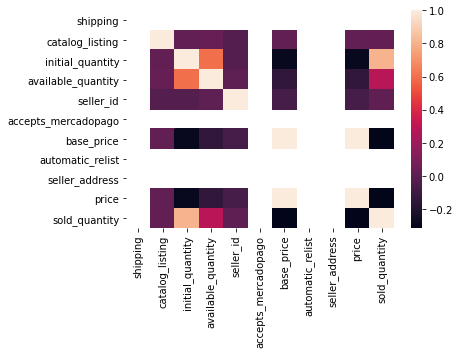

In [117]:
sns.heatmap(salida.corr(method='spearman'))


#### visualizing how parameters like mean, standard deviation and variance changes along the different categories.

<AxesSubplot:xlabel='CatName', ylabel='price'>

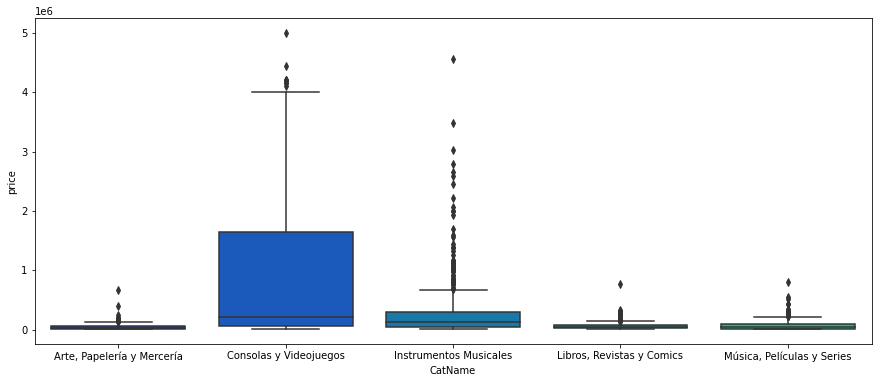

In [193]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='CatName',y='price',data=salida,palette='winter')

<AxesSubplot:xlabel='CatName', ylabel='sold_quantity'>

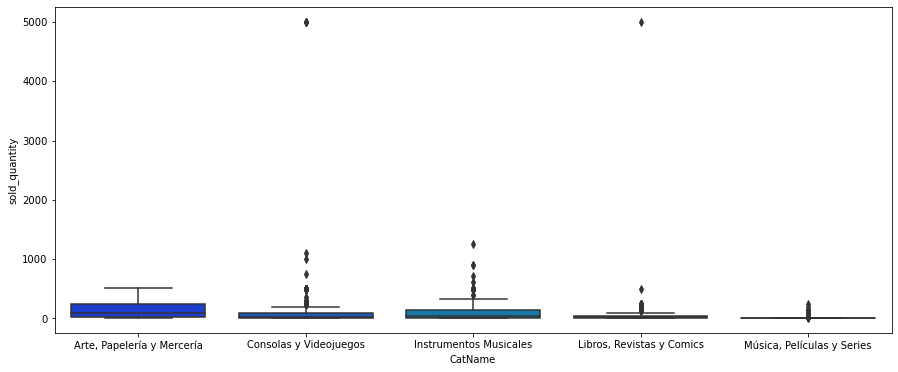

In [194]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='CatName',y='sold_quantity',data=salida,palette='winter')

#### understanding if the price depends on the number of articles availables and the historical sales.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

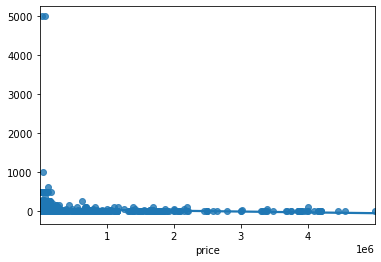

In [199]:
C_avQ_soldQ=salida['sold_quantity']/salida['available_quantity']
sns.regplot(salida['price'],C_avQ_soldQ)

# Model

## Dataset construction

For this dataset it was performed the same methodology as in "Exploration and Analysis". All caregories were used except for "other categories". Number of articles requested was increased to 15000 (duplicated drop not included) 

### Part 1

In [11]:
#For this dataset all caregories were used except for "other categories"
lCatRef2=dfCat.drop([31])


In [12]:
def ds2(inp='insert category id'):
    """
    This function constructs a data set from an array that contains data frames of products from categories chosen, 
    making a request to 'https://api.mercadolibre.com/sites/MCO/search?category=%parameters' and then it merges them to a final 
    dataframe
    Input should be an array with categories and name categories
    Initial number of products it is defined by cond (asociated to number of result pages to be indexed) and number of 
    categories
    Deletes duplicated products
    """           
            
 #df split
    cat=list(inp['id'])
    cName=list(inp['name'])
    #
    urls=[]
    originals_cat=pd.DataFrame([])# dataframe constructed to replace category_id column in order to keep only parent categories
    arr = np.arange(len(cat))
    cond= [0,50,100,150,200,250,300,350]
    arr2= np.arange(len(cond))
    for i in arr:
        ref=cat[i]
        ref3=cName[i]
        for p in range(500): 
            originals_cat=originals_cat.append({'category_id':ref,'CatName':ref3}, ignore_index=True)
        for k in arr2:
            ref2=cond[k]
            urli='https://api.mercadolibre.com/sites/MCO/search?category={}&offset={}&limit=50'.format(ref,ref2)
            urls.append(urli)
            
        
            
            dfs=list(np.zeros(len(urls)))
    arr3=np.arange(len(urls))
    #parent
    for j in arr3:
        reqRef=rq.get(urls[j])
        rRefJ=reqRef.json()
        resRef=rRefJ['results']
        dfName='dfs{}'.format(j)
        dfName=pd.DataFrame(resRef)
        dfs[j]=dfName
  
    cct=pd.concat(dfs, ignore_index=True)
    cct['category_id']=originals_cat['category_id']
    cct['CatName']=originals_cat['CatName']
    cct.drop_duplicates(subset ="id",keep = 'first', inplace = True)#duplicates elimination, useful for elements that might be in multiple categories, can't be used if dtype=object is present
    cct2=cct.reset_index(drop=True)#index reorganization
      
    return cct2

In [13]:
data_Model_cat=ds2(lCatRef2)
data_Model_cat.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11584 entries, 0 to 11583
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    11584 non-null  object 
 1   site_id               11584 non-null  object 
 2   title                 11584 non-null  object 
 3   seller                11584 non-null  object 
 4   price                 11325 non-null  float64
 5   prices                11580 non-null  object 
 6   sale_price            0 non-null      object 
 7   currency_id           11325 non-null  object 
 8   available_quantity    11584 non-null  int64  
 9   sold_quantity         11584 non-null  int64  
 10  buying_mode           11584 non-null  object 
 11  listing_type_id       11584 non-null  object 
 12  stop_time             11584 non-null  object 
 13  condition             11184 non-null  object 
 14  permalink             11584 non-null  object 
 15  thumbnail          

In [14]:
data_Model_cat.head()

,id,site_id,title,seller,price,prices,sale_price,currency_id,available_quantity,sold_quantity,...,domain_id,catalog_product_id,tags,catalog_listing,use_thumbnail_id,order_backend,differential_pricing,seller_contact,location,CatName
0,MCO625583466,MCO,Aspiradora Truper Aspi-06 23l 120v,"{'id': 147458773, 'permalink': None, 'registra...",279999.0,"{'id': 'MCO625583466', 'prices': [{'id': '3', ...",None,COP,2,7,...,MCO-VACUUM_CLEANERS,MCO15961655,"[good_quality_picture, loyalty_discount_eligib...",True,True,1,NaN,NaN,NaN,Accesorios para Vehículos
1,MCO580277325,MCO,Rodamiento Balinera 6000 2rs 10x26x8mm Zsg,"{'id': 213750849, 'permalink': None, 'registra...",4000.0,"{'id': 'MCO580277325', 'prices': [{'id': 'b6f8...",None,COP,50,500,...,MCO-VEHICLE_SEALS,None,"[good_quality_picture, good_quality_thumbnail,...",NaN,True,2,NaN,NaN,NaN,Accesorios para Vehículos
2,MCO513393961,MCO,Pijama Para Carro En Algodón Impermeable Talla L,"{'id': 336172490, 'permalink': None, 'registra...",150000.0,"{'id': 'MCO513393961', 'prices': [{'id': '2', ...",None,COP,1,500,...,MCO-CARS_AND_VANS_COVERS,None,"[good_quality_picture, good_quality_thumbnail,...",NaN,True,3,{'id': 33602181},NaN,NaN,Accesorios para Vehículos
3,MCO509093160,MCO,Radio Carro Bluetooth + Camara Usb Sd Pantalla...,"{'id': 212962423, 'permalink': None, 'registra...",229900.0,"{'id': 'MCO509093160', 'prices': [{'id': '71',...",None,COP,200,5000,...,MCO-VEHICLE_MULTIMEDIA_SYSTEMS,None,"[dragged_bids_and_visits, good_quality_picture...",NaN,True,4,NaN,NaN,NaN,Accesorios para Vehículos
4,MCO601526402,MCO,Par Bombillos Luz Led Moto O Carro 16000 Lm H4...,"{'id': 339523103, 'permalink': None, 'registra...",58900.0,"{'id': 'MCO601526402', 'prices': [{'id': '55',...",None,COP,50,500,...,MCO-VEHICLE_LED_BULBS,None,"[good_quality_picture, good_quality_thumbnail,...",NaN,True,5,{'id': 33602181},NaN,NaN,Accesorios para Vehículos


In [15]:
#input for ds2_f
id_list_model=data_Model_cat[['id','category_id','CatName']]
id_list_model.head()

,id,category_id,CatName
0,MCO625583466,MCO1747,Accesorios para Vehículos
1,MCO580277325,MCO1747,Accesorios para Vehículos
2,MCO513393961,MCO1747,Accesorios para Vehículos
3,MCO509093160,MCO1747,Accesorios para Vehículos
4,MCO601526402,MCO1747,Accesorios para Vehículos


### Part 2

To obtain the data from each article a new dataframe was constructed. Function `ds1_f` defined previously was used. 

In [16]:
salida_model=ds1_f(id_list_model['id'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11584 entries, 0 to 11583
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   title                        11584 non-null  object 
 1   status                       11584 non-null  object 
 2   shipping                     0 non-null      float64
 3   buying_mode                  11584 non-null  object 
 4   listing_source               11584 non-null  object 
 5   catalog_listing              11584 non-null  bool   
 6   stop_time                    11584 non-null  object 
 7   initial_quantity             11584 non-null  int64  
 8   currency_id                  11325 non-null  object 
 9   subtitle                     0 non-null      object 
 10  site_id                      11584 non-null  object 
 11  id                           11584 non-null  object 
 12  available_quantity           11584 non-null  int64  
 13  international_de

In [21]:
salida_model['CatName']=id_list_model['CatName']
salida_model['category_id']=id_list_model['category_id']
salida_model.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11584 entries, 0 to 11583
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   title                        11584 non-null  object 
 1   status                       11584 non-null  object 
 2   shipping                     0 non-null      float64
 3   buying_mode                  11584 non-null  object 
 4   listing_source               11584 non-null  object 
 5   catalog_listing              11584 non-null  bool   
 6   stop_time                    11584 non-null  object 
 7   initial_quantity             11584 non-null  int64  
 8   currency_id                  11325 non-null  object 
 9   subtitle                     0 non-null      object 
 10  site_id                      11584 non-null  object 
 11  id                           11584 non-null  object 
 12  available_quantity           11584 non-null  int64  
 13  international_de

In [17]:
salida_model.head()

,title,status,shipping,buying_mode,listing_source,catalog_listing,stop_time,initial_quantity,currency_id,subtitle,...,health,automatic_relist,warranty,condition,seller_address,price,sold_quantity,date_created,parent_item_id,CatName
0,Aspiradora Truper Aspi-06 23l 120v,active,NaN,buy_it_now,,True,2041-05-15T04:00:00.000Z,9,COP,None,...,None,False,Garantía de fábrica: 12 meses,new,NaN,279999,5,2021-05-20T23:31:49.000Z,None,Accesorios para Vehículos
1,Rodamiento Balinera 6000 2rs 10x26x8mm Zsg,active,NaN,buy_it_now,,False,2040-08-26T04:00:00.000Z,811,COP,None,...,0.85,False,Garantía del vendedor: 12 meses,new,NaN,4000,500,2020-08-31T23:52:50.000Z,None,Accesorios para Vehículos
2,Pijama Para Carro En Algodón Impermeable Talla L,active,NaN,buy_it_now,,False,2039-05-11T04:00:00.000Z,1459,COP,None,...,0.88,False,Garantía de fábrica: 30 días,new,NaN,150000,500,2019-05-16T18:50:18.000Z,None,Accesorios para Vehículos
3,Radio Carro Bluetooth + Camara Usb Sd Pantalla...,active,NaN,buy_it_now,,False,2039-04-02T04:00:00.000Z,5946,COP,None,...,0.75,False,Garantía del vendedor: 30 días,new,NaN,229900,5000,2019-04-07T20:33:15.000Z,MCO506453615,Accesorios para Vehículos
4,Par Bombillos Luz Led Moto O Carro 16000 Lm H4...,active,NaN,buy_it_now,,False,2041-05-23T21:40:10.000Z,862,COP,None,...,0.87,False,Garantía del vendedor: 6 meses,new,NaN,58900,500,2021-01-13T15:22:24.000Z,None,Accesorios para Vehículos


In [22]:
limp_salida_model=salida_model.drop(['status','accepts_mercadopago','buying_mode','parent_item_id','currency_id','automatic_relist','international_delivery_mode','differential_pricing','seller_address','official_store_id','subtitle','original_price','shipping'], axis=1)
limp_salida_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11584 entries, 0 to 11583
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               11584 non-null  object
 1   listing_source      11584 non-null  object
 2   catalog_listing     11584 non-null  bool  
 3   stop_time           11584 non-null  object
 4   initial_quantity    11584 non-null  int64 
 5   site_id             11584 non-null  object
 6   id                  11584 non-null  object
 7   available_quantity  11584 non-null  int64 
 8   listing_type_id     11584 non-null  object
 9   category_id         11584 non-null  object
 10  seller_id           11584 non-null  int64 
 11  start_time          11584 non-null  object
 12  base_price          11325 non-null  object
 13  last_updated        11584 non-null  object
 14  health              10526 non-null  object
 15  warranty            9341 non-null   object
 16  condition           11

In [23]:
limp_salida_model.head()

,title,listing_source,catalog_listing,stop_time,initial_quantity,site_id,id,available_quantity,listing_type_id,category_id,...,start_time,base_price,last_updated,health,warranty,condition,price,sold_quantity,date_created,CatName
0,Aspiradora Truper Aspi-06 23l 120v,,True,2041-05-15T04:00:00.000Z,9,MCO,MCO625583466,1,gold_special,MCO1747,...,2021-05-20T23:31:49.000Z,279999,2021-05-29T20:31:23.772Z,None,Garantía de fábrica: 12 meses,new,279999,5,2021-05-20T23:31:49.000Z,Accesorios para Vehículos
1,Rodamiento Balinera 6000 2rs 10x26x8mm Zsg,,False,2040-08-26T04:00:00.000Z,811,MCO,MCO580277325,50,gold_special,MCO1747,...,2020-08-31T23:52:50.000Z,4000,2021-05-25T22:22:13.000Z,0.85,Garantía del vendedor: 12 meses,new,4000,500,2020-08-31T23:52:50.000Z,Accesorios para Vehículos
2,Pijama Para Carro En Algodón Impermeable Talla L,,False,2039-05-11T04:00:00.000Z,1459,MCO,MCO513393961,1,gold_pro,MCO1747,...,2019-05-16T18:50:18.000Z,150000,2021-06-01T01:09:20.000Z,0.88,Garantía de fábrica: 30 días,new,150000,500,2019-05-16T18:50:18.000Z,Accesorios para Vehículos
3,Radio Carro Bluetooth + Camara Usb Sd Pantalla...,,False,2039-04-02T04:00:00.000Z,5946,MCO,MCO509093160,200,gold_special,MCO1747,...,2019-04-07T20:33:15.000Z,229900,2021-06-01T04:42:34.565Z,0.75,Garantía del vendedor: 30 días,new,229900,5000,2019-04-07T20:33:15.000Z,Accesorios para Vehículos
4,Par Bombillos Luz Led Moto O Carro 16000 Lm H4...,,False,2041-05-23T21:40:10.000Z,862,MCO,MCO601526402,50,gold_pro,MCO1747,...,2021-01-13T15:22:24.000Z,58900,2021-06-01T01:22:33.000Z,0.87,Garantía del vendedor: 6 meses,new,58900,500,2021-01-13T15:22:24.000Z,Accesorios para Vehículos


## Features

Features used to construct the model were choosen based con variables description, PCA and correlation between varibles (Pearson and Spearman)
Correlacion de Pearson(lin)o si no Spearman(no lineal), mirar suposiciones, regresiones lineales. 
mirar otras relaciones 
scikitlearn (training set test set)

In [26]:
set(limp_salida_model['catalog_listing'])

{False, True}

In [35]:
# last drop of columns. The following categories have to many unique values or are not relevant for the analysis 
dModel=limp_salida_model.drop(['title','stop_time','site_id','id','start_time','last_updated','warranty','date_created'],axis=1)
dModel.head(3)

,listing_source,catalog_listing,initial_quantity,available_quantity,listing_type_id,category_id,seller_id,base_price,health,condition,price,sold_quantity,CatName
0,,True,9,1,gold_special,MCO1747,147458773,279999,None,new,279999,5,Accesorios para Vehículos
1,,False,811,50,gold_special,MCO1747,213750849,4000,0.85,new,4000,500,Accesorios para Vehículos
2,,False,1459,1,gold_pro,MCO1747,336172490,150000,0.88,new,150000,500,Accesorios para Vehículos


In [36]:
#cuantitative variables
#cuant_dModel=dModel[['catalog_listing','initial_quantity','available_quantity','base_price','health','price','sold_quantity']]
dModel.describe(include='all')

,listing_source,catalog_listing,initial_quantity,available_quantity,listing_type_id,category_id,seller_id,base_price,health,condition,price,sold_quantity,CatName
count,11584,11584,11584.000000,11584.000000,11584,11584,1.158400e+04,11325.0,10526.0,11184,11325.0,11584.000000,11584
unique,5,2,NaN,NaN,4,25,NaN,3114.0,28.0,3,3114.0,NaN,25
top,,False,NaN,NaN,gold_special,MCO1367,NaN,39900.0,1.0,new,39900.0,NaN,Bebés
freq,11184,11495,NaN,NaN,6785,500,NaN,118.0,1457.0,10434,118.0,NaN,500
mean,NaN,NaN,752.779782,199.947600,NaN,NaN,2.816658e+08,NaN,NaN,NaN,NaN,169.630525,NaN
std,NaN,NaN,4384.910852,2143.519557,NaN,NaN,1.923691e+08,NaN,NaN,NaN,NaN,412.871490,NaN
min,NaN,NaN,1.000000,1.000000,NaN,NaN,7.683200e+04,NaN,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,24.000000,1.000000,NaN,NaN,1.327762e+08,NaN,NaN,NaN,NaN,5.000000,NaN
50%,NaN,NaN,126.000000,1.000000,NaN,NaN,2.384694e+08,NaN,NaN,NaN,NaN,50.000000,NaN
75%,NaN,NaN,495.000000,43.500000,NaN,NaN,4.203136e+08,NaN,NaN,NaN,NaN,241.000000,NaN


Remember we are only interested in the correlation with sold_quantity. In the case of pearson correlation it seems that any of the features are strongly correlated with sold_quantity

<AxesSubplot:>

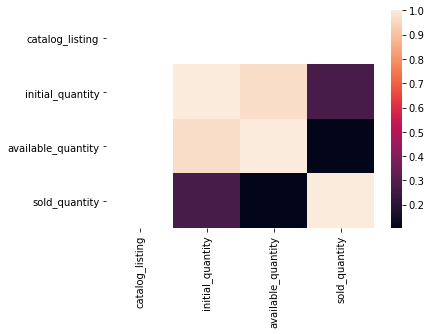

In [90]:
sns.heatmap(dModel.corr(method='pearson'))

When we take into account Spearman correlation(non-linear) a correlation with catatalog_listing can be seen. This means that a linear model maybe is not the best option. 

<AxesSubplot:>

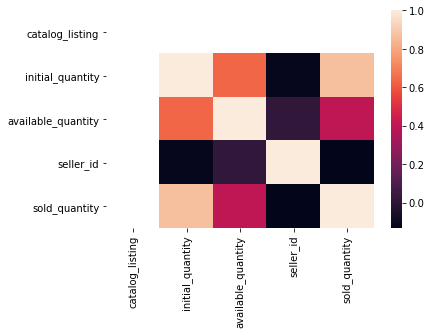

In [84]:
sns.heatmap(dModel.corr('spearman'))

<AxesSubplot:xlabel='sold_quantity', ylabel='initial_quantity'>

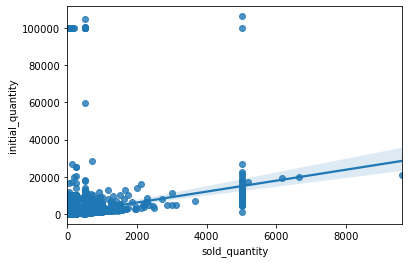

In [122]:
sns.regplot(dModel['sold_quantity'],dModel['initial_quantity'])

However, based in what it seen in the graph, a model of linear regression will be proposed and then compared with a random forest model


## Linear regression model/
### Round 1

### X and Y definition
for this model it is expected that the valiables'initial_quantity' and 'available_quantity' explain better the changes in 'sold_quantity'
### Train and test sets

in this case four more variables were also included to test the model. 

In [165]:
Y=dModel['sold_quantity']
X=dModel[['catalog_listing','initial_quantity','available_quantity','base_price','health','price']]

In [166]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=101) #20% test 80% train

### Model creation

In [167]:
lm = LinearRegression()
lm.fit(X_train,Y_train)

LinearRegression()

### Model testing

In [168]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
catalog_listing,0.000000e+00
initial_quantity,2.585622e-01
available_quantity,-4.899435e-01
base_price,-4.398774e-07
health,7.293565e+01
price,-4.773708e-07


From the values of the coefficients it can be seen the evaluated variables do not help to explain change in sold_quantity. Nevertheless, a further testing of the model is necessary

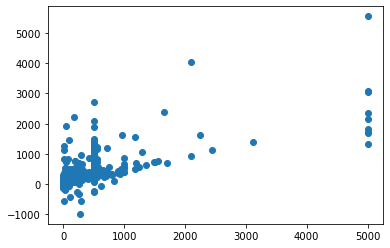

In [169]:
predictions = lm.predict(X_test)
plt.scatter(y_test,predictions) #predictions plot

In [170]:
lm.score(X_test, Y_test)

0.5361345208995697

As it can be seen from predictions plot and score for the regression, the model does predicts correctly the values of sold_quantity 
- Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE) were also calculated, so the analysis can be completed

In [171]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 121.69536438519211
MSE: 71126.94010883333
RMSE: 266.6963443859577


## round 2
### X and Y definition

In [172]:
Y2=dModel['sold_quantity']
X2=dModel[['initial_quantity','available_quantity']]

### Train and test sets

In [173]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=101) #20% test 80% train

### Model creation and testing

In [174]:
lm2 = LinearRegression()
lm2.fit(X2_train,Y2_train)

LinearRegression()

In [175]:
coeff_df2 = pd.DataFrame(lm2.coef_,X2.columns,columns=['Coefficient'])
coeff_df2

,Coefficient
initial_quantity,0.259432
available_quantity,-0.491489


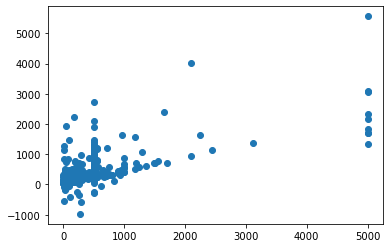

In [179]:
predictions2 = lm2.predict(X2_test)
plt.scatter(Y2_test,predictions2) #predictions plot

the values of the coefficients increased with respect to the values from the same variables in round 1. The rest of the parameters are presented below

In [181]:
lm2.score(X2_test, Y2_test)

0.535180257248987

In [184]:
print('MAE:', metrics.mean_absolute_error(Y2_test, predictions2))
print('MSE:', metrics.mean_squared_error(Y2_test, predictions2))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y2_test, predictions2)))

MAE: 122.62097337945609
MSE: 71273.26238669426
RMSE: 266.970527187355


Despite the difference between score, MAE, MSE and RMSE is very small, all values increased. This indicates that the rest of the variables not included in round 2 contribute to explain sold_quantity, however this contribution it is most likely not significant.

# To be explored... 

- It would be interesting to perform this same analysis taking into account time or image related attributes like `last_updated`,`date created`,`start_time`,`stop_time`and `thumbnail`
- For the linear regression model it is necessary to test different sets of X variables, like those that are categorical
-  To improve the prediction of the sold quantity it would be interesting to built a non-linear model 